In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Zip format
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -uq "/content/drive/MyDrive/leafdata.zip" -d "/content"

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [24]:
train_dir='/content/drive/MyDrive/Hariml/code/Training/Dataset'

In [25]:
Labels = ['Aloe_vera', 'Guava','Jasmine', 'Lemon','Mango', 'Mint','Neem', 'Tulsi']

In [26]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Aloe_vera
1 Guava
2 Jasmine
3 Lemon
4 Mango
5 Mint
6 Neem
7 Tulsi


In [27]:
print('Number of classes:',len(Labels))

Number of classes: 8


In [28]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [29]:
IMAGE_SIZE

(224, 224)

In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 902 images belonging to 8 classes.
Found 595 images belonging to 8 classes.


In [31]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [32]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [33]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 2,917,960
Trainable params: 659,976
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [38]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
56/56 [==============================] - 426s 8s/step - loss: 0.3126 - accuracy: 0.8962 - val_loss: 0.0446 - val_accuracy: 0.9831
Epoch 2/15
56/56 [==============================] - 66s 1s/step - loss: 0.0332 - accuracy: 0.9887 - val_loss: 0.0372 - val_accuracy: 0.9899
Epoch 3/15
56/56 [==============================] - 66s 1s/step - loss: 0.0335 - accuracy: 0.9887 - val_loss: 0.0919 - val_accuracy: 0.9662
Epoch 4/15
56/56 [==============================] - 66s 1s/step - loss: 0.0621 - accuracy: 0.9808 - val_loss: 0.0863 - val_accuracy: 0.9764
Epoch 5/15
56/56 [==============================] - 66s 1s/step - loss: 0.0682 - accuracy: 0.9797 - val_loss: 0.0511 - val_accuracy: 0.9797
Epoch 6/15
56/56 [==============================] - 66s 1s/step - loss: 0.0191 - accuracy: 0.9921 - val_loss: 0.0186 - val_accuracy: 0.9932
Epoch 7/15
56/56 [==============================] - 66s 1s/step - loss: 0.0108 - accuracy: 0.9944 - val_loss: 0.0347 - val_accuracy: 0.9882
Epoch 8/15
56/56 [=

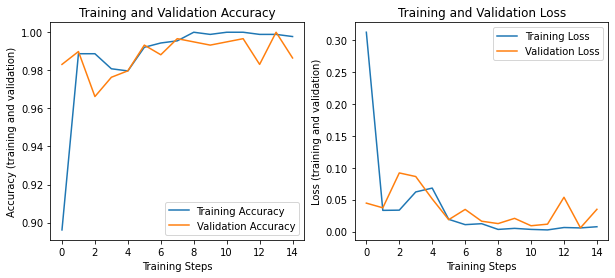

In [39]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

class: Aloe_vera, confidence: 1.000000


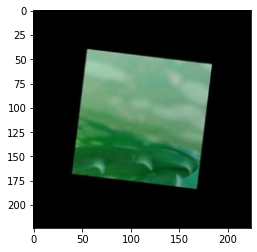

<Figure size 432x288 with 0 Axes>

class: Tulsi, confidence: 0.999985


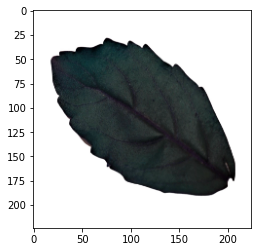

class: Mango, confidence: 1.000000


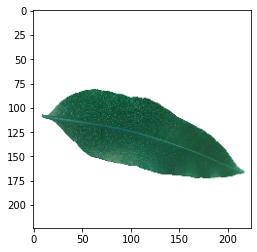

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


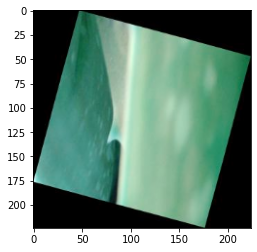

<Figure size 432x288 with 0 Axes>

class: Guava, confidence: 1.000000


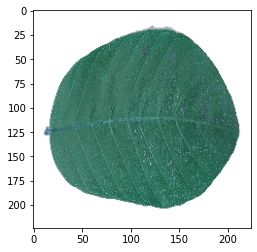

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 0.999999


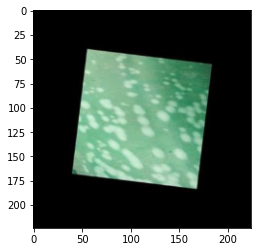

<Figure size 432x288 with 0 Axes>

class: Mango, confidence: 0.999999


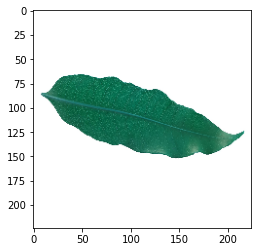

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


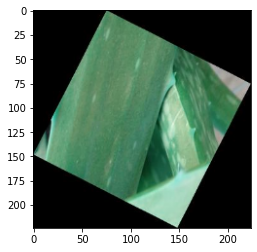

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 0.999999


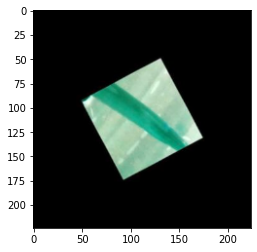

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


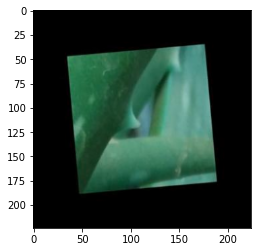

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 0.999999


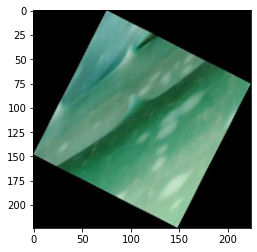

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


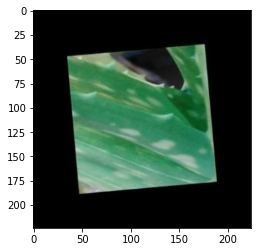

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


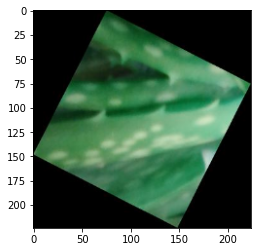

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


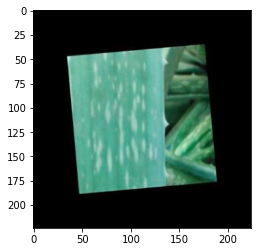

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


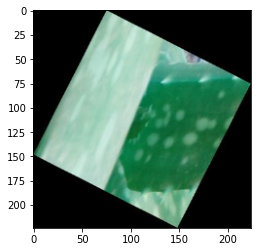

<Figure size 432x288 with 0 Axes>

class: Aloe_vera, confidence: 1.000000


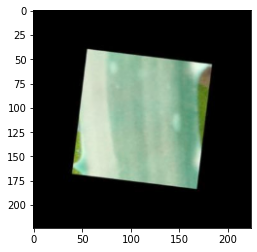

<Figure size 432x288 with 0 Axes>

In [40]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

Classification Report
              precision    recall  f1-score   support

   Aloe_vera       1.00      1.00      1.00       413
       Guava       0.84      1.00      0.91        26
     Jasmine       0.97      1.00      0.98        28
       Lemon       1.00      0.77      0.87        22
       Mango       1.00      1.00      1.00        24
        Mint       1.00      0.97      0.99        38
        Neem       1.00      1.00      1.00        24
       Tulsi       1.00      1.00      1.00        20

    accuracy                           0.99       595
   macro avg       0.98      0.97      0.97       595
weighted avg       0.99      0.99      0.99       595

38/38 [==============================] - 26s 682ms/step - loss: 0.0258 - accuracy: 0.9916
[0.025800146162509918, 0.9915966391563416]


Confusion Matrix


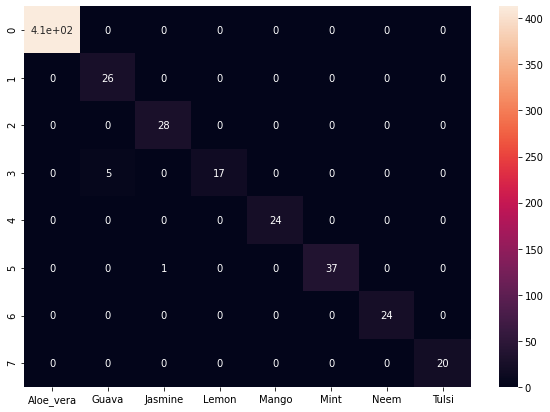

In [42]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [43]:
cd /content/drive/MyDrive/Hariml/code

/content/drive/MyDrive/Hariml/code


#Export as saved model and convert to TFLite

In [44]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1624457510/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1624457510/assets


'/tmp/saved_models/1624457510'

In [45]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [46]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: Aloe_vera, file: Aloe_vera/h1 (136).jpg
PREDICTED: class: Aloe_vera, confidence: 1.000000


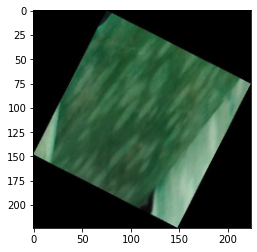

<Figure size 432x288 with 0 Axes>

SOURCE: class: Aloe_vera, file: Aloe_vera/h1 (1014).jpg
PREDICTED: class: Aloe_vera, confidence: 1.000000


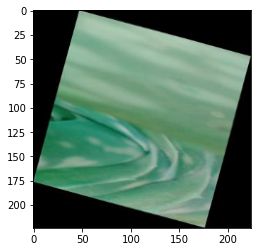

In [47]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [48]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11573084